In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import pandas as pd
import json
import pickle

# Local imports
from src.data_processing.lstm_data_preprocessing import reduce_time_bucket_features, FeaturesConfig, TimeBucketConfig
from src.data_processing.loader import load_time_bucket_data

In [3]:
# Load the model and details on configurations used to train the model like the time bucket data used and the features used

# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

model_folder = "../model_generation/trained_models/lstm_3_32"
model = load_model(os.path.join(model_folder, "model.keras"),
    custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
with open(os.path.join(model_folder, "config.json"), 'r') as f:
    configs = json.load(f)

features_config = FeaturesConfig(**configs["features_config"])
time_bucket_folder = configs["time_bucket_folder"]
test_size = configs["test_size"]

In [4]:
# Get the train test data set used to train the model were testing

X_scaler = StandardScaler()
y_scaler = StandardScaler()

token_time_buckets, time_bucket_config = load_time_bucket_data(time_bucket_folder)

token_datasets = []
for token_address, data in token_time_buckets.items():
    X = data["X"]
    y = data["y"]
    bucket_times = data["bucket_times"]

    # Only get the features listed in features_config
    X = reduce_time_bucket_features(X, features_config)

    token_datasets.append((X, y, token_address, bucket_times))

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)

In [5]:
results_file = os.path.join(model_folder, "test_results.pkl")

if os.path.exists(results_file):
    with open(results_file, "rb") as f:
        model_results = pickle.load(f)

    y_pred_actual = model_results["pred"]
    y_test_actual = model_results["real"]

else:
    y_pred = model.predict(X_test)

    # Inverse transform to get real values
    y_pred_actual = y_scaler.inverse_transform(y_pred)
    y_test_actual = y_scaler.inverse_transform(y_test)

    # Save predictions to model folder
    model_results = {"pred": y_pred_actual, "real": y_test_actual}
    with open(results_file, "wb") as f:
        pickle.dump(model_results, f)

In [6]:
from visualisation_methods import plot_error_distribution, plot_directional_accuracy, plot_prediction_vs_actual, plot_magnitude_accuracy, plot_value_distributions

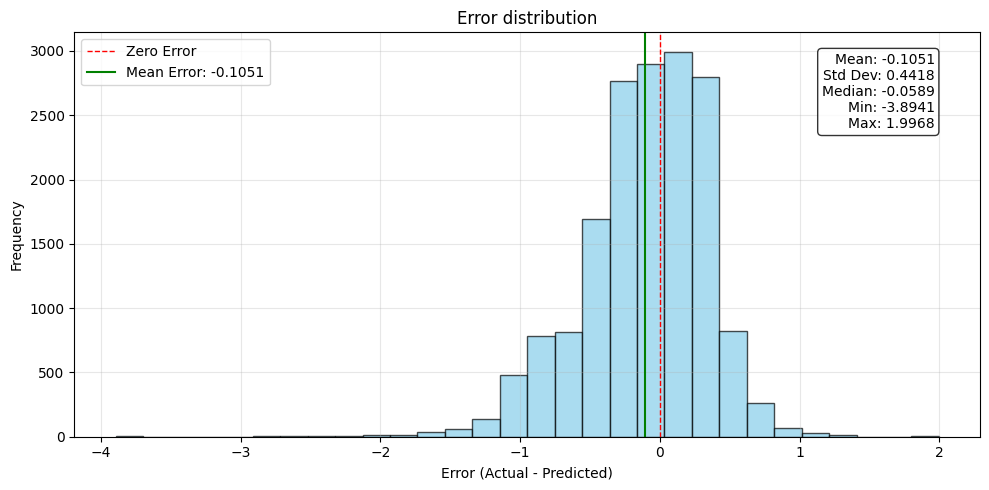

In [7]:
plot_error_distribution(y_pred_actual, y_test_actual, title="Error distribution")

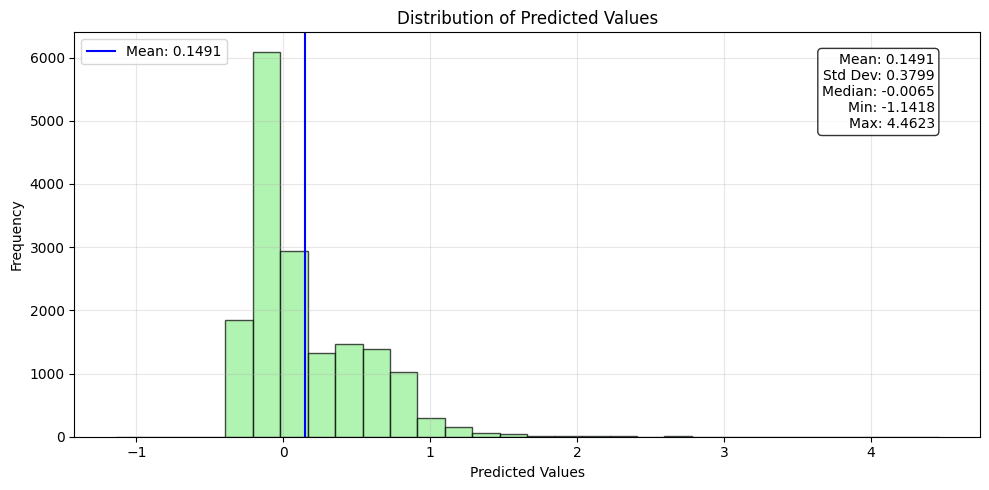

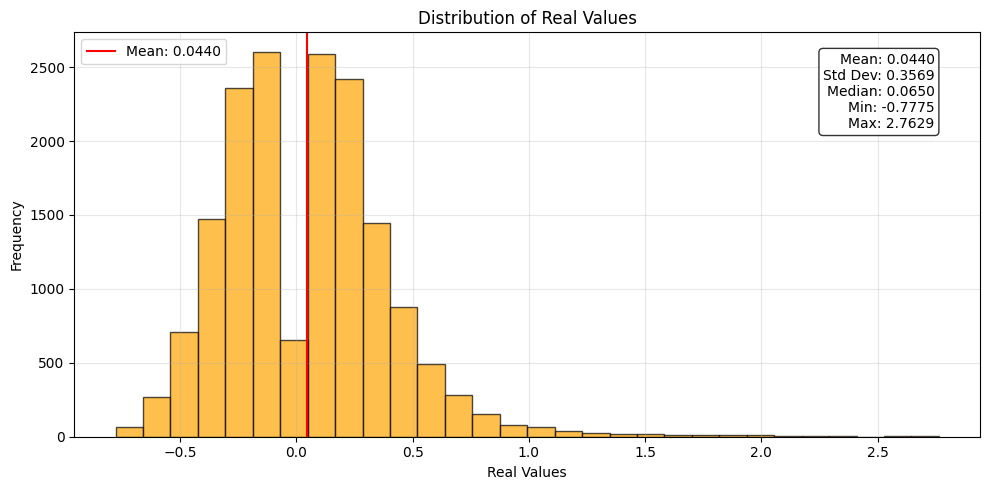

In [8]:
plot_value_distributions(y_pred_actual, y_test_actual)

In [9]:
print(max(y_pred_actual))

[4.462288]


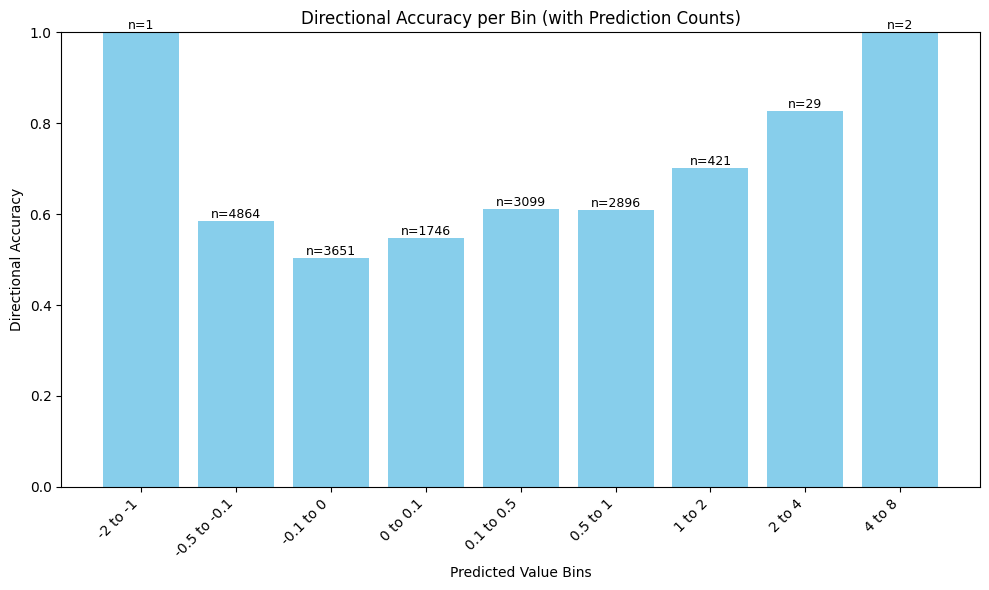

({'-2 to -1': np.float64(1.0),
  '-0.5 to -0.1': np.float64(0.5851151315789473),
  '-0.1 to 0': np.float64(0.5034237195288962),
  '0 to 0.1': np.float64(0.5481099656357389),
  '0.1 to 0.5': np.float64(0.6101968376895773),
  '0.5 to 1': np.float64(0.6094613259668509),
  '1 to 2': np.float64(0.7007125890736342),
  '2 to 4': np.float64(0.8275862068965517),
  '4 to 8': np.float64(1.0)},
 {'-2 to -1': np.int64(1),
  '-0.5 to -0.1': np.int64(4864),
  '-0.1 to 0': np.int64(3651),
  '0 to 0.1': np.int64(1746),
  '0.1 to 0.5': np.int64(3099),
  '0.5 to 1': np.int64(2896),
  '1 to 2': np.int64(421),
  '2 to 4': np.int64(29),
  '4 to 8': np.int64(2)})

In [10]:
bins = [-np.inf, -8, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, 8, np.inf]
plot_directional_accuracy(y_pred_actual, y_test_actual, bins=bins)

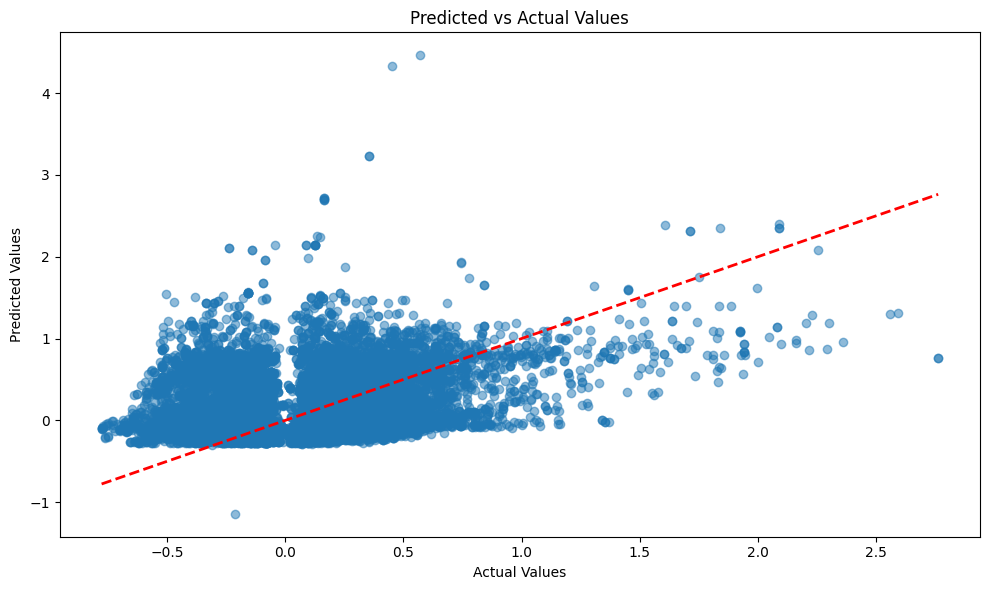

In [11]:
plot_prediction_vs_actual(y_pred_actual, y_test_actual)

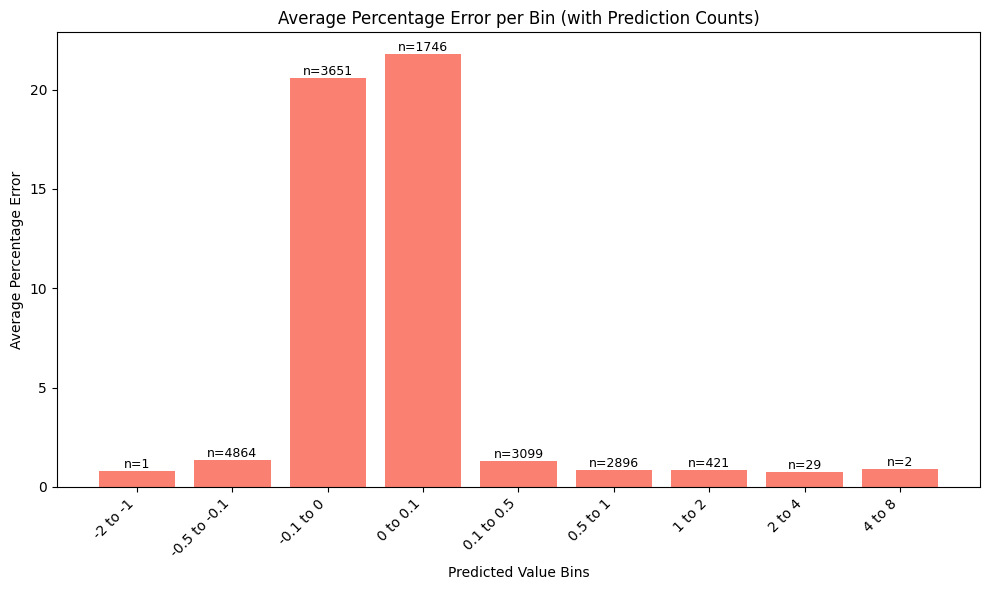

({'-2 to -1': np.float64(0.8138318770820818),
  '-0.5 to -0.1': np.float64(1.3595993272855031),
  '-0.1 to 0': np.float64(20.595987858061587),
  '0 to 0.1': np.float64(21.798569793033252),
  '0.1 to 0.5': np.float64(1.2794321470033183),
  '0.5 to 1': np.float64(0.8585885068513787),
  '1 to 2': np.float64(0.8243962416940767),
  '2 to 4': np.float64(0.7535415441174126),
  '4 to 8': np.float64(0.8841112045717252)},
 {'-2 to -1': np.int64(1),
  '-0.5 to -0.1': np.int64(4864),
  '-0.1 to 0': np.int64(3651),
  '0 to 0.1': np.int64(1746),
  '0.1 to 0.5': np.int64(3099),
  '0.5 to 1': np.int64(2896),
  '1 to 2': np.int64(421),
  '2 to 4': np.int64(29),
  '4 to 8': np.int64(2)})

In [12]:
plot_magnitude_accuracy(y_pred_actual, y_test_actual, bins=bins, use_percentage_error=True)

In [13]:
def get_test_tokens_with_large_pred(token_datasets, test_size, y_pred_actual, min_abs_pred_size=1.5):
    total_buckets = sum(len(data[1]) for data in token_datasets)
    test_start_idx = int((1 - test_size) * total_buckets)

    fully_test_tokens = {}
    current_idx = 0
    y_pred_test_index = 0  # Index within y_pred_actual

    for X, y, token_address, bucket_times in token_datasets:
        token_len = len(y)
        token_start_idx = current_idx
        current_idx += token_len

        # Only process tokens fully in the test set
        if token_start_idx >= test_start_idx:
            bucket_pred_map = []

            for i in range(token_len):
                if y_pred_test_index >= len(y_pred_actual):
                    break  # Prevent overflow if mismatch in lengths
                pred = y_pred_actual[y_pred_test_index].item()
                if abs(pred) >= min_abs_pred_size:
                    bucket_pred_map.append({
                        'bucket_time': tuple(bucket_times[i]),
                        'prediction': pred
                    })
                y_pred_test_index += 1

            if bucket_pred_map:
                fully_test_tokens[token_address] = bucket_pred_map

    return fully_test_tokens


In [14]:
from src.data_processing.loader import load_token_price_data
from metrics_methods import test_trailing_strategy, print_strategy_results

# Get all min_abs_pred_size x predictions and their tokens
min_abs_pred_size = 1.5
test_tokens_pred = get_test_tokens_with_large_pred(token_datasets, test_size, y_pred_actual, min_abs_pred_size=min_abs_pred_size)

# Load price data
tokens_tx_data = {
    token: load_token_price_data(token, use_datetime=False)
    for token in test_tokens_pred.keys()
}

results = test_trailing_strategy(test_tokens_pred, tokens_tx_data)

print_strategy_results(results)


Simulating for token: FSCzQMCcu82sswEPgKbfr6VjqBFYd9xqGVDyphDp2y4A
  Prediction: 2.2559714317321777x | Buy Price: 4.587424e-08 (with slippage/fees)
    Sold 50% at 50.0% | Price: 7.508666e-08
    Hold time expired, sold all remaining | Price: 8.110987e-08

Simulating for token: FvLD1NGU1b7dnXB3SwAHEELFzwcX2zJXJKcntvKEpump
  Prediction: 1.5066323280334473x | Buy Price: 1.866835e-07 (with slippage/fees)
    Sold 50% at 50.0% | Price: 2.428146e-07
    Hold time expired, sold all remaining | Price: 2.515266e-07

Simulating for token: H34pU2AHt5NPJLe657t9TH8LnguZr6CZ4L68GSmFpump
  Prediction: 1.7534172534942627x | Buy Price: 3.641183e-07 (with slippage/fees)

Simulating for token: H6bqH81ektWmkQum81t2WtHaChod2MW3Sk6kh5Ltpump
  Prediction: 1.6585590839385986x | Buy Price: 1.932503e-07 (with slippage/fees)
    Trailing stop 50.0% hit | Price: 1.098485e-07
    Hold time expired, sold all remaining | Price: 1.470798e-07

Simulating for token: He4wd7rakEdApfAqKkjWDrK5XTinY2aQUE9Q6VPNpump
  Pred